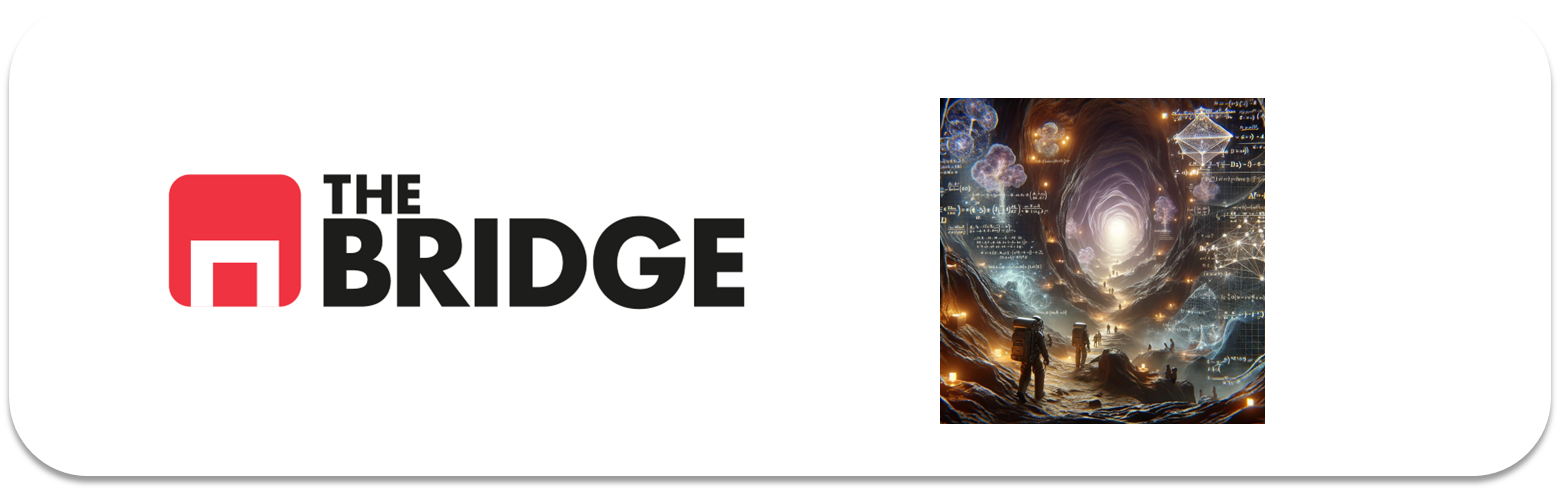

## PRACTICA OBLIGATORIA: **Introducción Deep Learning**

* La práctica obligatoria de esta unidad consiste en un único ejercicio de modelado del dataset del titanic empleando y comparando dos modelos diferentes. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [135]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

import toolbox_martin as tbm


### Descripción y objetivo

El objetivo de la práctica es crear un modelo DL y compararlo con un modelo Random Forest para el dataset de titanic los dos con el mismo objetivo, predecir la supervivencia de un pasajero.  Se pide:  
1. Desarrollar el proceso de ML hasta crear los dos modelos DL y Random Forest. El primero debe tener una topología MLP (es decir una red densa) con un máximo de 3 capas ocultas y debes emplear sklearn para crearlo. No es necesario hacer una análisis/seleccion exahustivo. Escoge una métrica acorde al tipo de target del problema. 

2. Ambos modelos deben tener sus hiperparámetros optimizados, mediante GridSearch. Para ello: utiliza el grid de parámetros que creas conveniente para Random Forest y para el modelo DL, utiliza un grid con los hiperparámetros siguientes:'hidden_layer_sizes','activation', 'solver','alpha' y 'learning_rate'. Para los rangos del grid del modelo de DL guíate por lo visto en el workout y por los posibles valores que se indican en la [documentación](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier). Prueba por lo menos una topología con una sola capa oculta y otra con más de una capa oculta.   
NOTA: Incluye los valores por defecto de los hiperparámetros escogidos en cada caso dentro del grid de hiperparámetros. 
  

3. Compara los modelos respecto a sus métricas medias de accuracy, precision, recall y tiempos de entrenamiento (para ello tendrás que realizar un entrenamiento a parte del mejor modelo obtenido en la optimización de hiperparámetros) y decide cuál te quedarías argumentándolo.    

4. Para el mejor modelo DL obtenido, muestra su clasification report, y la matriz de confusión comentando el resultado.


In [65]:
df=pd.read_csv("./data/titanic.csv")

In [66]:
df.sample(5)

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
612,1,3,female,NaN,1,0,15.5000,Q,Third,woman,False,NaN,Queenstown,yes,False
409,0,3,female,NaN,3,1,25.4667,S,Third,woman,False,NaN,Southampton,no,False
851,0,3,male,74.0,0,0,7.7750,S,Third,man,True,NaN,Southampton,no,True
8,1,3,female,27.0,0,2,11.1333,S,Third,woman,False,NaN,Southampton,yes,False
533,1,3,female,NaN,0,2,22.3583,C,Third,woman,False,NaN,Cherbourg,yes,False


In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   survived     891 non-null    int64  
 1   pclass       891 non-null    int64  
 2   sex          891 non-null    object 
 3   age          714 non-null    float64
 4   sibsp        891 non-null    int64  
 5   parch        891 non-null    int64  
 6   fare         891 non-null    float64
 7   embarked     889 non-null    object 
 8   class        891 non-null    object 
 9   who          891 non-null    object 
 10  adult_male   891 non-null    bool   
 11  deck         203 non-null    object 
 12  embark_town  889 non-null    object 
 13  alive        891 non-null    object 
 14  alone        891 non-null    bool   
dtypes: bool(2), float64(2), int64(4), object(7)
memory usage: 92.4+ KB


In [68]:
tbm.analizar_df(df)

,Columna,Tipo,Cardinalidad,% Cardinalidad,Numero de nulos,% Nulos
0,survived,int64,2,0.224467,0,0.000000
1,pclass,int64,3,0.336700,0,0.000000
2,sex,object,2,0.224467,0,0.000000
3,age,float64,88,9.876543,177,19.865320
4,sibsp,int64,7,0.785634,0,0.000000
5,parch,int64,7,0.785634,0,0.000000
6,fare,float64,248,27.833895,0,0.000000
7,embarked,object,3,0.336700,2,0.224467
8,class,object,3,0.336700,0,0.000000
9,who,object,3,0.336700,0,0.000000


In [69]:
# actuamos sobre los nulos
# embarked
df["embarked"].fillna(df["embarked"].mode()[0], inplace=True)


In [70]:
# age
hombres_mean = df.loc[df['who'] == 'man', 'age'].mean()
mujeres_mean = df.loc[df['who'] == 'woman', 'age'].mean()
menores_mean = df.loc[df['who'] == 'child', 'age'].mean()

df.loc[(df['who'] == 'man') & (df['age'].isna()), 'age'] = hombres_mean
df.loc[(df['who'] == 'woman') & (df['age'].isna()), 'age'] = mujeres_mean
df.loc[(df['who'] == 'child') & (df['age'].isna()), 'age'] = menores_mean

In [71]:
# deck vamos a rellenar con UKN
df["deck"].fillna("UNK",inplace=True)

In [72]:
# usamos otro df para evitar columnas sin importancia
rampa_salida=['embark_town','sibsp', 'parch', 'class', 'who','adult_male', 'alive']

In [73]:
tbm.analizar_df(df)

,Columna,Tipo,Cardinalidad,% Cardinalidad,Numero de nulos,% Nulos
0,survived,int64,2,0.224467,0,0.000000
1,pclass,int64,3,0.336700,0,0.000000
2,sex,object,2,0.224467,0,0.000000
3,age,float64,89,9.988777,0,0.000000
4,sibsp,int64,7,0.785634,0,0.000000
5,parch,int64,7,0.785634,0,0.000000
6,fare,float64,248,27.833895,0,0.000000
7,embarked,object,3,0.336700,0,0.000000
8,class,object,3,0.336700,0,0.000000
9,who,object,3,0.336700,0,0.000000


In [74]:
df["deck"].value_counts()

deck
UNK    688
C       59
B       47
D       33
E       32
A       15
F       13
G        4
Name: count, dtype: int64

In [75]:
# hacemos unos mapeados para quitar categoricas
df["sex"]=df["sex"].map({"male":0,"female":1})
df["embarked"]=df["embarked"].map({"Q":0,"S":1,"C":2})
df["deck"]=df["deck"].map(
    {"UNK":0,
     "A":1,
     "B":2,
     "C":3,
     "D":4,
     "E":5,
     "F":6,
     "G":7})
df["alone"]=df["alone"].map({False:0,True:1})

In [76]:
# trabajo sobre este dataframe
df2=df.drop(rampa_salida, axis=1)
df2.sample(5)

,survived,pclass,sex,age,fare,embarked,deck,alone
631,0,3,0,51.000000,7.0542,1,0,1
360,0,3,0,40.000000,27.9000,1,0,0
55,1,1,0,33.173123,35.5000,1,3,1
296,0,3,0,23.500000,7.2292,2,0,1
254,0,3,1,41.000000,20.2125,1,0,0


In [77]:
# target
target="survived"

In [85]:
# train y test
X=df2.drop(target,axis=1)
y=df2[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

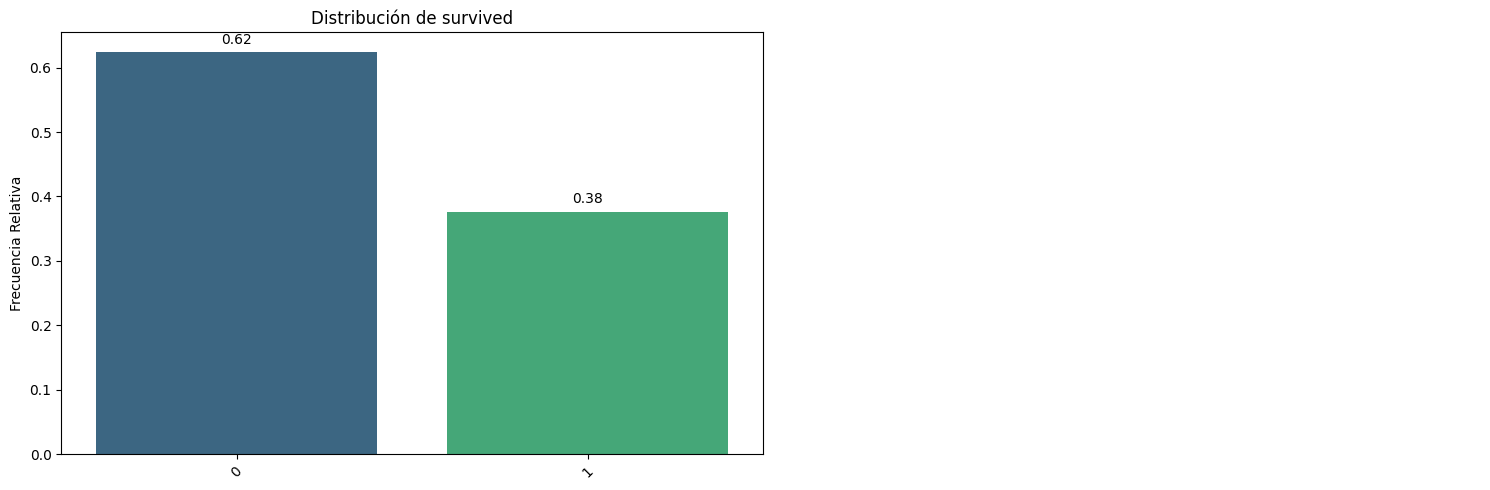

In [79]:
tbm.pinta_distribucion_categoricas(train_set,[target], relativa=True,mostrar_valores=True)

bastante desbalanceado usaremos la metrica recall

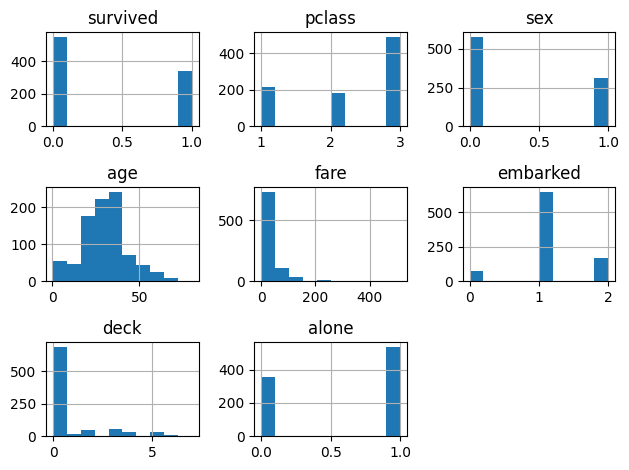

In [82]:
# MiniEDA
df2.hist()
plt.tight_layout()


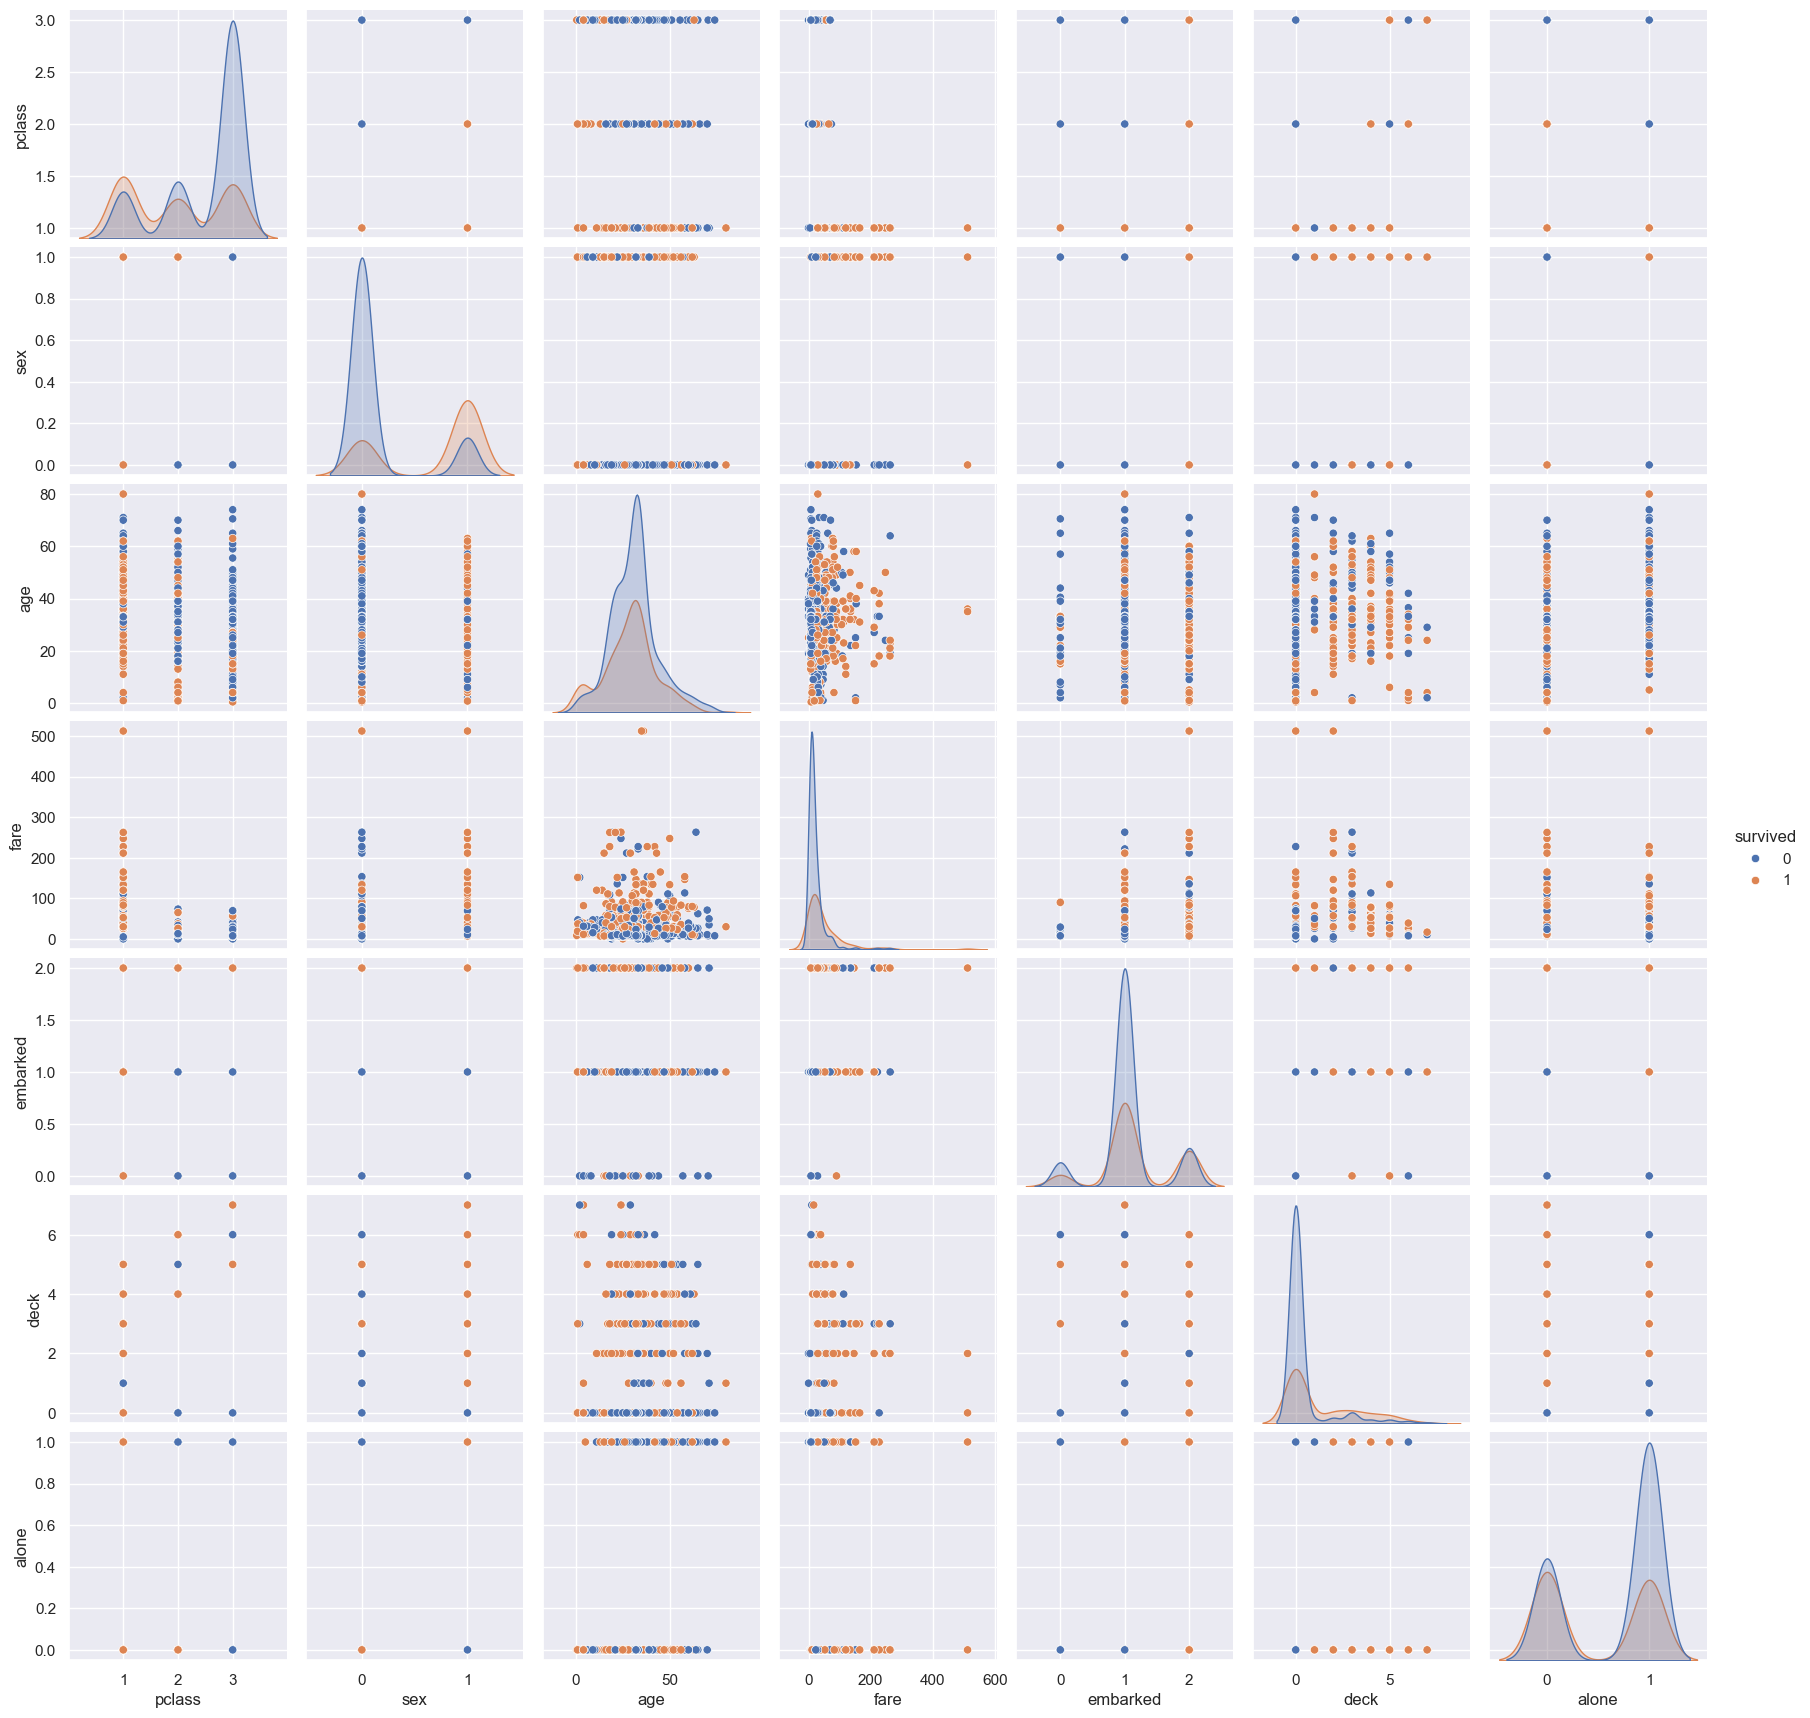

In [93]:
sns.pairplot(df2,hue=target)

In [86]:
# vemos la importancia de cada feature
modelo_inicial = RandomForestClassifier(random_state=42)
modelo_inicial.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [95]:
importance=modelo_inicial.feature_importances_
importance

array([0.07893215, 0.25453595, 0.26306228, 0.27516079, 0.03608995,
       0.06843354, 0.02378536])

In [96]:
for i, importancia in enumerate(importance):
    print(f'Feature {X.columns[i]}: {importance}')

Feature pclass: [0.07893215 0.25453595 0.26306228 0.27516079 0.03608995 0.06843354
 0.02378536]
Feature sex: [0.07893215 0.25453595 0.26306228 0.27516079 0.03608995 0.06843354
 0.02378536]
Feature age: [0.07893215 0.25453595 0.26306228 0.27516079 0.03608995 0.06843354
 0.02378536]
Feature fare: [0.07893215 0.25453595 0.26306228 0.27516079 0.03608995 0.06843354
 0.02378536]
Feature embarked: [0.07893215 0.25453595 0.26306228 0.27516079 0.03608995 0.06843354
 0.02378536]
Feature deck: [0.07893215 0.25453595 0.26306228 0.27516079 0.03608995 0.06843354
 0.02378536]
Feature alone: [0.07893215 0.25453595 0.26306228 0.27516079 0.03608995 0.06843354
 0.02378536]


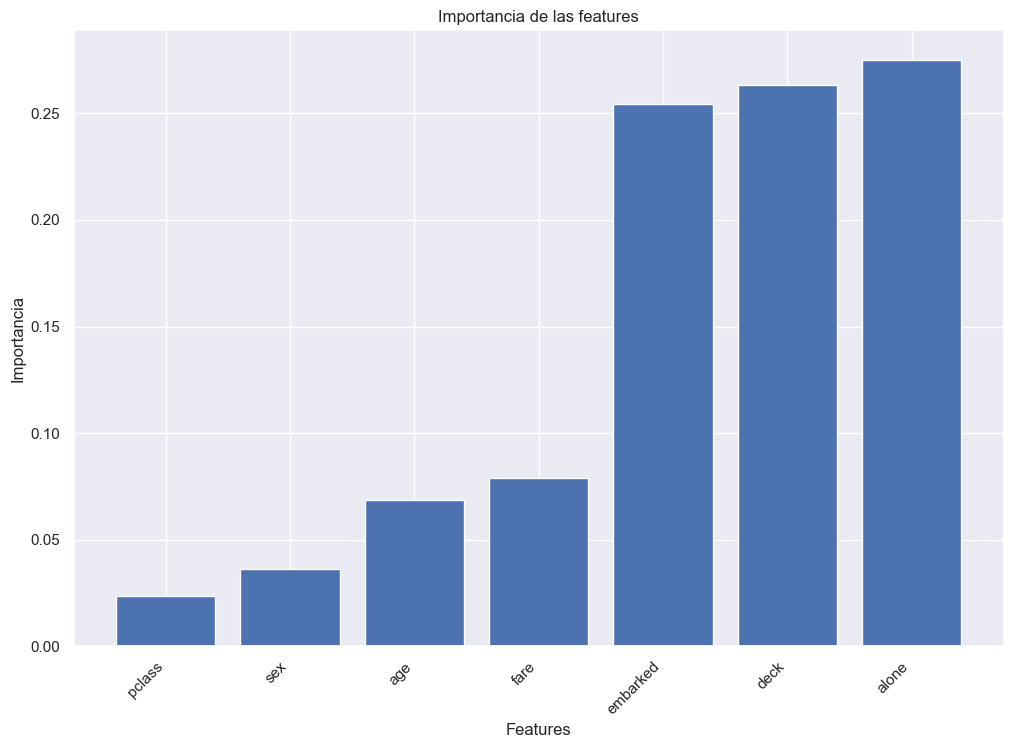

In [110]:
# Crea un gráfico de barras de la importancia de las características
plt.figure(figsize=(12, 8))
plt.bar(range(len(importance)), sorted(importance), tick_label=X_train.columns)
plt.xlabel('Features')
plt.ylabel('Importancia')
plt.title('Importancia de las features')
plt.xticks(rotation=45, ha='right')

# Muestra el gráfico
plt.show()


In [113]:
# antes de modelar vamos a hacer una operacion log a fare
df["fare_log"]=np.log1p(df["fare"])

In [118]:
df2=df.drop(rampa_salida, axis=1)

In [122]:
# entrenamiento

scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [126]:
# modelo base --> RF

# Crear el modelo RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Predicciones en el conjunto de prueba
rf_predictions = rf_model.predict(X_test)

Random Forest Accuracy: 0.8156


In [133]:
# Crear el objeto GridSearchCV
rf_grid = {
    'n_estimators': [25, 50, 75, 100, 200],
    'max_depth': [None, 5, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_grid_search = GridSearchCV(estimator=rf_model, param_grid=rf_grid, cv=5, scoring='balanced_accuracy')

# Ajustar la búsqueda en cuadrícula a los datos
rf_grid_search.fit(X_train, y_train)

# Mejor modelo
best_rf_model = rf_grid_search.best_estimator_
best_rf_predictions = best_rf_model.predict(X_test)

# Métrica de evaluación - precisión para el modelo optimizado
rf_test_predictions = best_rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_test_predictions)
rf_precision = precision_score(y_test, rf_test_predictions)
rf_recall = recall_score(y_test, rf_test_predictions)

print("Random Forest Metrics:")
print(f"Accuracy: {rf_accuracy:.4f}")
print(f"Precision: {rf_precision:.4f}")
print(f"Recall: {rf_recall:.4f}")


Random Forest Metrics:
Accuracy: 0.8212
Precision: 0.8000
Recall: 0.7568


In [134]:
# Modelo MLP (Red Neuronal)
mlp_model = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=1000, random_state=42)
mlp_model.fit(X_train, y_train)

# Predicciones en el conjunto de prueba
mlp_predictions = mlp_model.predict(X_test)

In [136]:
# modelo MLP
mlp_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'activation': ['relu', 'tanh',],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive']
}

# Crear el modelo MLPClassifier
mlp_model = MLPClassifier(random_state=42, max_iter=500)
# Crear el objeto GridSearchCV
mlp_search = GridSearchCV(estimator=mlp_model, param_grid=mlp_grid, cv=5, scoring='balanced_accuracy')
mlp_search.fit(X_train_scaled, y_train)

# Obtener el mejor modelo de mlp después de la búsqueda en cuadrícula
best_mlp_model = mlp_search.best_estimator_

mlp_test_predictions = best_mlp_model.predict(X_test_scaled)
mlp_accuracy = accuracy_score(y_test, mlp_test_predictions)
mlp_precision = precision_score(y_test, mlp_test_predictions)
mlp_recall = recall_score(y_test, mlp_test_predictions)

print("\nDeep Learning Metrics:")
print(f"Accuracy: {mlp_accuracy:.4f}")
print(f"Precision: {mlp_precision:.4f}")
print(f"Recall: {mlp_recall:.4f}")

c:\Users\Martín Ámez Segovia\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Martín Ámez Segovia\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Martín Ámez Segovia\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Martín Ámez Segovia\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic 


Deep Learning Metrics:
Accuracy: 0.7933
Precision: 0.7681
Recall: 0.7162


In [137]:
# 3.2 Tiempos de entrenamiento
import time

rf_start_time = time.time()
best_rf_model.fit(X_train, y_train)
rf_training_time = time.time() - rf_start_time

dl_start_time = time.time()
best_mlp_model.fit(X_train_scaled, y_train)
dl_training_time = time.time() - dl_start_time

print("\nTraining Times:")
print(f"Random Forest Training Time: {rf_training_time:.2f} seconds")
print(f"Deep Learning Training Time: {dl_training_time:.2f} seconds")


Training Times:
Random Forest Training Time: 0.54 seconds
Deep Learning Training Time: 4.06 seconds


In [139]:
# Obtener predicciones y probabilidades para el mejor modelo de DL
dl_test_probabilities = best_mlp_model.predict_proba(X_test_scaled)[:, 1]

# Configuración de umbral para las predicciones de DL
dl_threshold = 0.5
dl_test_predictions_threshold = (dl_test_probabilities >= dl_threshold).astype(int)

# Clasification Report para el mejor modelo de DL
dl_classification_report = classification_report(y_test, dl_test_predictions_threshold)
print("\nClassification Report (Deep Learning):\n", dl_classification_report)



Classification Report (Deep Learning):
               precision    recall  f1-score   support

           0       0.81      0.85      0.83       105
           1       0.77      0.72      0.74        74

    accuracy                           0.79       179
   macro avg       0.79      0.78      0.78       179
weighted avg       0.79      0.79      0.79       179



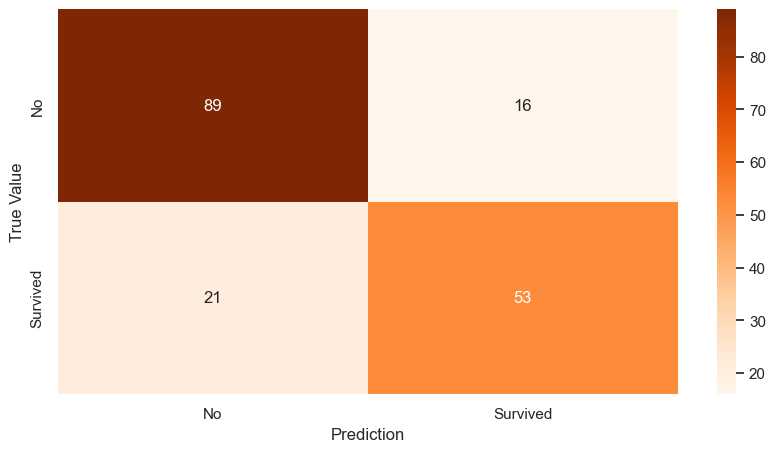

In [151]:
# Obtener la matriz de confusión
dl_confusion_matrix = confusion_matrix(y_test, dl_test_predictions_threshold)

# Crear el mapa de calor
plt.figure(figsize=(10, 5))
sns.heatmap(dl_confusion_matrix, annot=True, cmap='Oranges', 
            xticklabels=['No', 'Survived'], 
            yticklabels=['No', 'Survived'])
plt.xlabel('Prediction')
plt.ylabel('True Value')
plt.show()